# Логистическая регрессия в задаче классификации успеха маркетинговой кампании

Загрузим необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

## Логистическая регрессия

Несмотря на название, данный метод применяется именно в задачах классификации. Регрессия служит указанием на то, что мы пытаемся предсказать вероятность принадлежности классу.

Метод основан на минимизации логистической функции потерь:

$$L(y_{true}, y_{predicted}) = \sum_{i=1}^n \ln (1 + e^{-y_{true} \cdot y_{predicted}}) \rightarrow \min_w,$$
где $y_{predicted}$ вычисляется по формуле $y_{predicted} = <w, x>$. Минимизация функции потерь происходит методом градиентного спуска.

In [67]:
from sklearn.linear_model import LogisticRegression

## Датасет

Датасет, содержащит информацию о клиентах и маркетинговой кампании некоторого банка. Наша задача $-$ предсказать успешность кампании для каждого клиента. Признаками являются различные характеристики клиента и кампании.

Ссылка на датасет: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [68]:
# Считаем данные
from google.colab import drive
drive.mount('/content/drive/')
data = pd.read_csv('/content/drive/My Drive/data/bank-additional-full.csv', sep=';')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [69]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [71]:
X = data.iloc[:, :-1].copy()
y = data.iloc[:, -1].copy()

<Axes: >

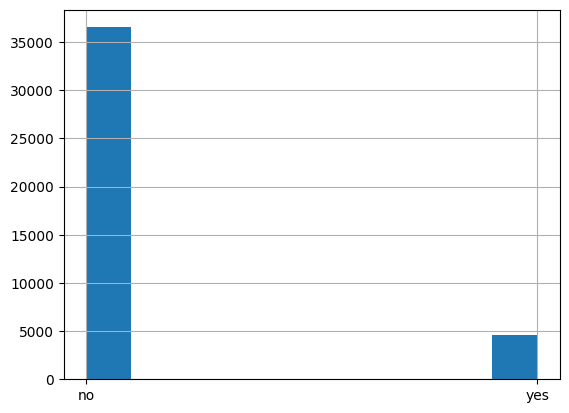

In [72]:
# посмотрим на распределение значений целевого признака
y.hist()

Классы очень несбалансированы:

In [73]:
#преобразуем метки классов в массив бинарных значений.
y = LabelBinarizer().fit_transform(y).ravel()
y.mean()

0.11265417111780131

Заметим, что среди признаков достаточно много категориальных, в то время как линейные модели работают с числовыми признаками.

Одним из способов получить числовые значения категориальных параметров является **one-hot encoding**. Его суть состоит в том, что для каждого категориального признака $f$ и каждого его значения $v$ создается новый признак, который равен 1 если у объекта значение $f$ равно $v$, и 0 $-$ иначе.

One-hot encoding с помощью pandas :

In [74]:
X = pd.get_dummies(X)


X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  int64  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  job_admin.                     41188 non-null  uint8  
 11  job_blue-collar                41188 non-null  uint8  
 12  job_entrepreneur               41188 non-null 

In [75]:
X.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0


Разобьем выборку на трейн и тест:

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Обучим линейный SVM с балансировкой классов:

In [77]:
from sklearn.svm import SVC

In [78]:
model_svm = SVC(kernel='linear', class_weight='balanced')
model_svm.fit(X_train, y_train)

y_pred = model_svm.predict(X_test)
print('Test accuracy: ', accuracy_score(y_test, y_pred))
print('Test F measure: ', f1_score(y_test, y_pred))

Test accuracy:  0.8824957513959699
Test F measure:  0.5526802218114603


Обучим логистическую регрессию.

In [79]:
from sklearn.linear_model import LogisticRegression
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

y_predicted = model_logistic.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Построим график зависимости F-меры от порога положительного класса:

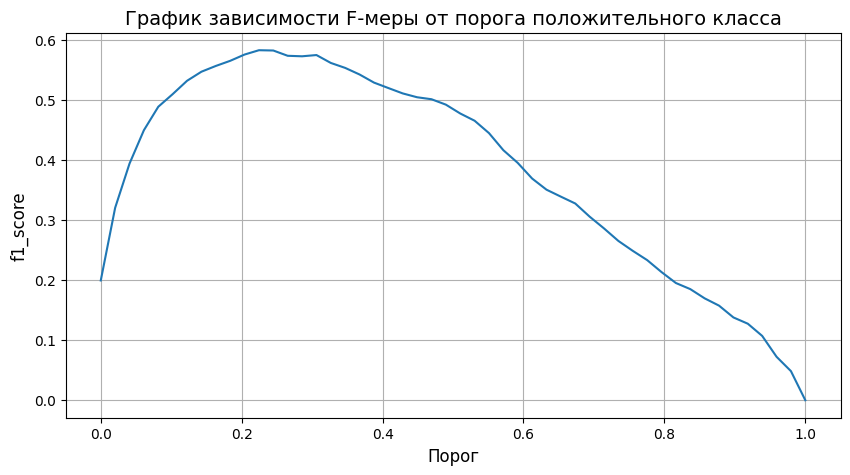

In [80]:
grid = np.linspace(0, 1, 50)
plt.figure(figsize=(10,5))
plt.title('График зависимости F-меры от порога положительного класса', fontsize=14)
plt.plot(grid, [f1_score(y_test, y_predicted > item) for item in grid])
plt.grid()
plt.xlabel('Порог', fontsize=12)
plt.ylabel('f1_score', fontsize=12);

In [81]:
print('Test accuracy: ', accuracy_score(y_test, y_predicted > 0.2))
print('Test F measure: ', f1_score(y_test, y_predicted > 0.2))
print('Test ROC-AUC: ', roc_auc_score(y_test, y_predicted))

Test accuracy:  0.8817674192765235
Test F measure:  0.5728070175438597
Test ROC-AUC:  0.919997150260308


In [82]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Построение дерева решений. max_depth - максимальная глубина дерева
dectree = DecisionTreeClassifier(max_depth=4, random_state=21)
# обучаем на обучающей выборке
dectree.fit(X_train,y_train)
#считаем точность Accuracy на тестовой выборке
dectree.score(X_test,y_test)

0.9088370963826171

In [83]:
# Построение случайного леса. max_depth - максимальная глубина дерева, n_estimators - количество деревьев
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 30,  max_depth=5,  random_state=21)
rfc.fit(X_train, y_train)
rfc.score (X_test, y_test)

0.9020393299344501

In [84]:
# построим матрицу ошибок классификации для случайного леса
from sklearn.metrics import confusion_matrix

y_pred=rfc.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,7274,52
1,755,157


In [85]:
#посчитаем более объективную метрику f1
from sklearn.metrics import f1_score
f1_score(y_test,y_pred)

0.280107047279215

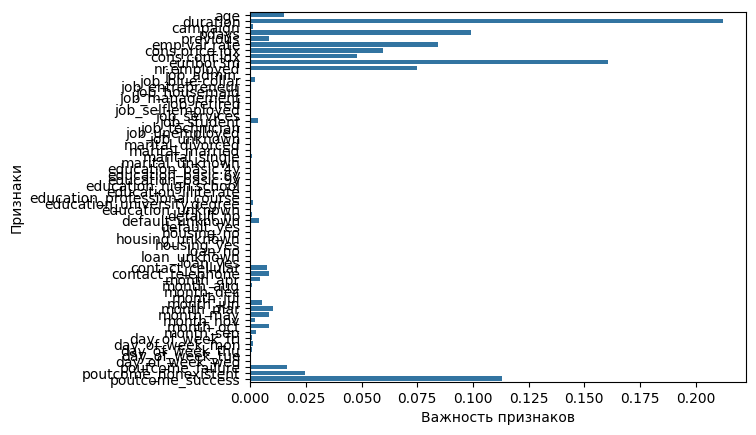

In [86]:
# посмотрим на значимость признаков согласно RandomForest
import seaborn as sns
sns.barplot(x=rfc.feature_importances_, y=X_test.columns)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.show()

In [87]:
import xgboost as xgb

In [88]:
from xgboost import XGBClassifier
cl = XGBClassifier(n_estimators = 30, max_depth = 5, random_state=21)
cl.fit(X_train,y_train)
cl.score(X_test, y_test)

0.9150279193979121

In [89]:
# построим матрицу ошибок классификации для градиентного бустинга
y_pred=cl.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,7058,268
1,432,480


In [90]:
#посчитаем более объективную метрику f1 для градиентного бустинга
f1_score(y_test,y_pred)

0.5783132530120482

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

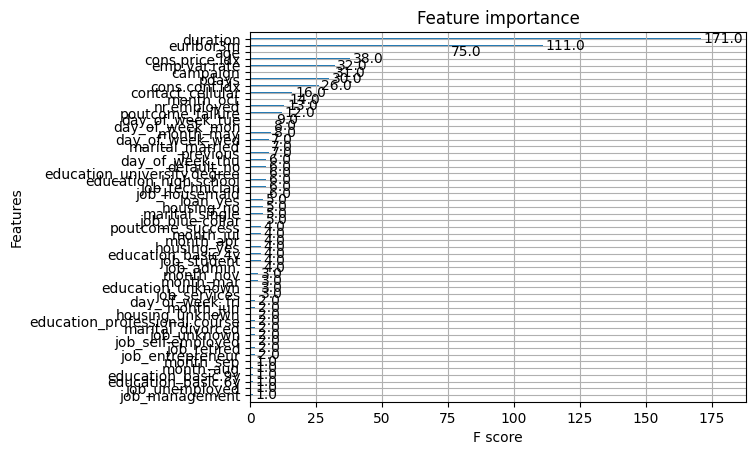

In [91]:
# посмотрим на значимость признаков согласно xgboost
xgb.plot_importance(cl)